## Setup environment

In [1]:

from monai.utils import first, set_determinism
from monai.transforms import (EnsureChannelFirstd, Compose, CropForegroundd, LoadImaged, Orientationd, RandCropByPosNegLabeld, ScaleIntensityRanged, Spacingd)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset
from monai.apps import download_and_extract
from monai.transforms import CenterSpatialCropd
from monai.transforms import Resized
import torch
import matplotlib.pyplot as plt
import os
import glob
import torch.nn as nn

from datetime import datetime


In [2]:
data_dir = '/home/shahpouriz/Data/Practic/ASC-PET-001'
directory = '/home/shahpouriz/Data/Practic/LOG'

## Set dataset path

In [3]:

train_images = sorted(glob.glob(os.path.join(data_dir, "NAC", "*.nii.gz")))
target_images = sorted(glob.glob(os.path.join(data_dir, "MAC", "*.nii.gz")))

# data_dicts = [{"image": img, "target": tar} for img in train_images]
data_dicts = [{"image": img, "target": tar} for img, tar in zip(train_images, target_images)]

# test_files = data_dicts[-24:]
test_files = data_dicts[-1:]

# Extracting file names from val_files
val_file_names = [os.path.basename(file_dict["target"]) for file_dict in test_files]
print(val_file_names)
set_determinism(seed=0)


['007067_C5_RJ_.nii.gz']


In [ ]:
# # Info about the data
# import nibabel as nib
# import os

# def get_nifti_info(nifti_file):
#     """Returns the shape and size of the NIfTI file."""
#     nifti_img = nib.load(nifti_file)
#     data = nifti_img.get_fdata()
#     shape = data.shape
#     size = data.size
#     return shape, size

# # Assuming data_dicts is defined as shown above
# val_files = data_dicts

# for file_dict in val_files:
#     image_path = file_dict["image"]
#     target_path = file_dict["target"]

#     image_shape, image_size = get_nifti_info(image_path)
#     target_shape, target_size = get_nifti_info(target_path)

#     print(f"Image: {os.path.basename(image_path)}, Shape: {image_shape}, Size: {image_size}")
#     print(f"Target: {os.path.basename(target_path)}, Shape: {target_shape}, Size: {target_size}")


In [16]:
val_transforms = Compose(
    [   LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
        Spacingd(keys=["image", "target"], pixdim=(1.5, 1.5, 2.0)),
        Resized(keys=["image", "target"], spatial_size=(96, 96, 96), mode=('bilinear')),
        # CenterSpatialCropd(keys=["image", "target"], roi_size=crop_size, lazy=True),

    ])


val_ds = CacheDataset(data=test_files, transform=val_transforms, cache_rate=1.0, num_workers=1)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1)



Loading dataset: 100%|██████████| 1/1 [00:08<00:00,  8.22s/it]


image shape: torch.Size([180, 180, 312]), target shape: torch.Size([180, 180, 312])


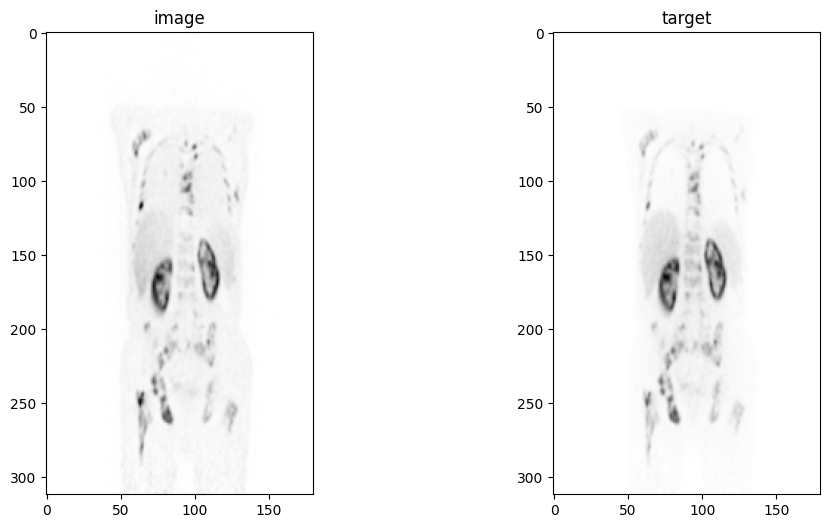

In [5]:
import numpy as np
check_ds = Dataset(data=test_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, target = (check_data["image"][0][0], check_data["target"][0][0])
print(f"image shape: {image.shape}, target shape: {target.shape}")
# plot the slice [:, :, n]
n = 105

plt.figure("check", (12, 6))

plt.subplot(1, 2, 1)
plt.title("image")
# Rotate the image slice and then display it
rotated_image = np.rot90(image[:, n, :])
plt.imshow(rotated_image, cmap="gist_yarg")

plt.subplot(1, 2, 2)
plt.title("target")
# Rotate the target slice and then display it
rotated_target = np.rot90(target[:, n, :])
plt.imshow(rotated_target, cmap='gist_yarg')

plt.show()


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(32, 64, 128, 256),  # Increased channel sizes and an additional layer
    act=(nn.ReLU6, {"inplace": True}),
    strides=(2, 2, 2, 2),  # Adjust strides if needed
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)



/home/shahpouriz/Data/new_env/lib64/python3.11/site-packages/monai/networks/nets/unet.py:133: UserWarning: `len(strides) > len(channels) - 1`, the last 1 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")


In [22]:
from utils import find_last_best_model
log_filename = 'log_1_24_15_44.txt'
log_filepath = directory + '/'+ log_filename
bestmodel_filename, best_metric, best_epoch = find_last_best_model(log_filepath)
print(f"Last Best Model Saved as: {bestmodel_filename}, Best Metric: {best_metric}, Epoch: {best_epoch}")


Last Best Model Saved as: model_1_24_18_48.pth, Best Metric: 0.1938, Epoch: 230


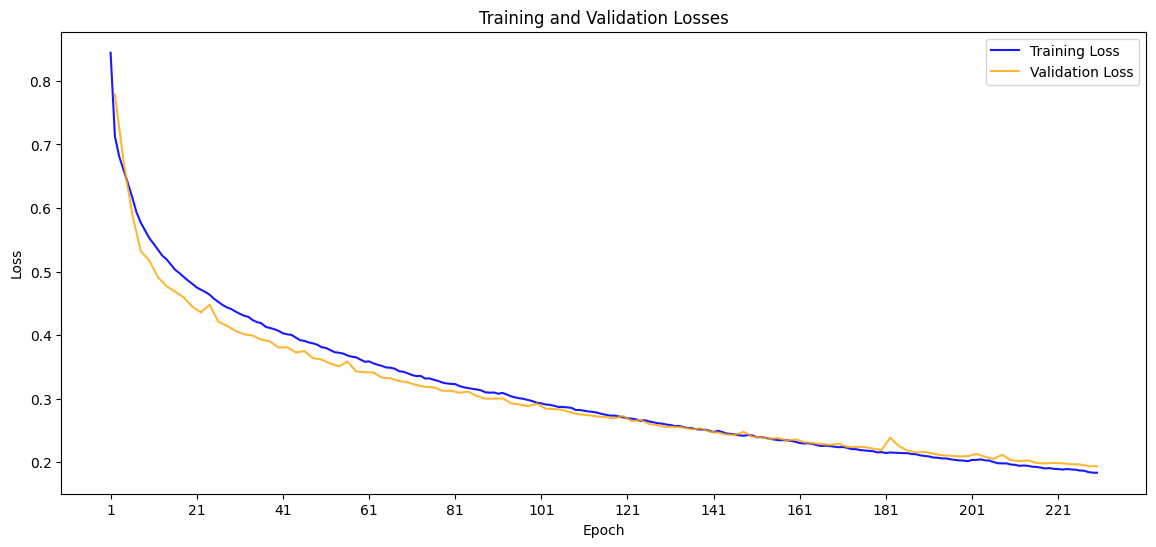

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Function to parse the loss values from the log file
def parse_loss_values(log_filepath):
    train_losses = []
    val_losses = []
    with open(log_filepath, 'r') as file:
        for line in file:
            if 'average loss:' in line:
                loss_value = float(line.split(': ')[-1])
                train_losses.append(loss_value)
            if 'Validation loss:' in line:
                val_loss_value = float(line.split(': ')[-1])
                val_losses.append(val_loss_value)
    return train_losses, val_losses


train_losses, val_losses = parse_loss_values(log_filepath)

max_epochs = len(train_losses)
val_interval = 2  # Update this if your validation interval is different

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(range(1, max_epochs + 1), train_losses, label='Training Loss', color='blue', alpha=0.9)
plt.plot(range(2, max_epochs + 1, val_interval), val_losses, label='Validation Loss', color='orange', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.xticks(np.arange(1, max_epochs + 1, 20))  # Adjust the x-axis ticks if needed
plt.show()


In [24]:
import torch


def load_model(directory, model_filename):
    model_path = os.path.join(directory, model_filename)
    if os.path.exists(model_path):
        print(f"Model file {model_filename} is loading.")
        # Load the model onto the CPU
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    else:
        print(f"Model file {model_filename} not found.")





def find_model_info(log_filepath, model_filename):
    best_metric = None
    epoch = None
    with open(log_filepath, 'r') as file:
        for line in file:
            if model_filename in line:
                parts = line.split(',')
                best_metric = float(parts[1].split(': ')[1])  # Extract best metric
                epoch = int(parts[2].split(': ')[1])  # Extract epoch number
                return model_filename, best_metric, epoch
    return model_filename, best_metric, epoch


# Usage
model_filename_to_find = bestmodel_filename
# model_filename_to_find = 'model_1_22_18_3.pth'

load_model(directory, model_filename_to_find)

bestmodel_filename, best_metric, best_epoch = find_model_info(log_filepath, model_filename_to_find)
print(f"Model: {bestmodel_filename}, Best Metric: {best_metric}, Epoch: {best_epoch}")

Model file model_1_24_18_48.pth is loading.
Model: model_1_24_18_48.pth, Best Metric: 0.1938, Epoch: 230


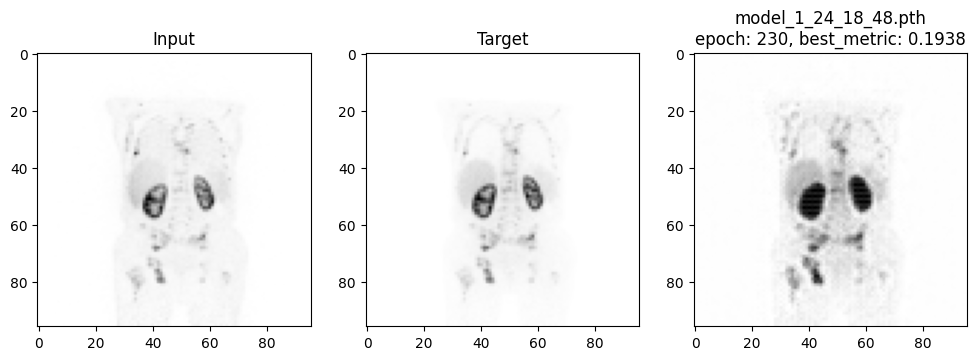

In [41]:
def visualize_results_whole(val_data, model, n, title):
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_data["image"].to(device))

    plt.figure("check", (12, 6))

    plt.subplot(1, 3, 1)
    plt.title(f"Input")
    input_slice = np.rot90(val_data["image"][0, 0, :, n, :])
    plt.imshow(input_slice, cmap="gist_yarg")

    plt.subplot(1, 3, 2)
    plt.title(f"Target")
    target_slice = np.rot90(val_data["target"][0, 0, :, n, :])
    plt.imshow(target_slice, cmap="gist_yarg")

    plt.subplot(1, 3, 3)
    plt.title(title)
    output_slice = np.rot90(val_outputs.detach().cpu()[0, 0, :, n, :])
    plt.imshow(output_slice, cmap="gist_yarg")
    
    plt.show()

# Usage
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        n = 57
        visualize_results_whole(val_data, model, n, f"{bestmodel_filename}\nepoch: {best_epoch}, best_metric: {best_metric}")
        if i == 0:
            break


------------------
# Quantification Evaluation

In [90]:
import numpy as np
import torch
from skimage.metrics import structural_similarity as ssim
from math import log10, sqrt

def mean_error(predicted, reference):
    return np.mean(predicted - reference)

def mean_absolute_error(predicted, reference):
    return np.mean(np.abs(predicted - reference))

def relative_error(predicted, reference, epsilon=0.3):
    return np.mean((predicted - reference) / (reference + epsilon)) * 100

def absolute_relative_error(predicted, reference, epsilon=0.3):
    return np.mean(np.abs(predicted - reference) / (reference + epsilon)) * 100

def rmse(predicted, reference):
    return sqrt(np.mean((predicted - reference) ** 2))

def psnr(predicted, reference, peak):
    mse = np.mean((predicted - reference) ** 2)
    return 20 * log10(peak / sqrt(mse))

def calculate_ssim(predicted, reference):
    return ssim(predicted, reference, data_range=reference.max() - reference.min())


In [91]:
model.eval()
with torch.no_grad():
    for i, data in enumerate(val_loader):
        inputs, targets = data["image"].to(device), data["target"].to(device)
        outputs = model(inputs)
        # # Print the shape of outputs and targets
        # print("Output shape:", outputs.shape)
        # print("Target shape:", targets.shape)
        #         # The number of channels is the second element in the shape tuple
        # num_channels = outputs.shape[1]
        # print("Number of channels in output:", num_channels)

        # Convert to numpy arrays
        outputs_np = (outputs.cpu().numpy())*5
        targets_np = (targets.cpu().numpy())*5

        # Assuming single-channel data, remove channel dimension
        outputs_np = np.squeeze(outputs_np, axis=1)
        targets_np = np.squeeze(targets_np, axis=1)

        # Calculate metrics for each image in the batch
        for output, target in zip(outputs_np, targets_np):
            peak = np.max([output.max(), target.max()])  # For PSNR
            print("Mean Error:", mean_error(output, target))
            print("Mean Absolute Error:", mean_absolute_error(output, target))
            print("Relative Error (%):", relative_error(output, target))
            print("Absolute Relative Error (%):", absolute_relative_error(output, target))
            print("RMSE:", rmse(output, target))
            print("PSNR:", psnr(output, target, peak))
            print("SSIM:", calculate_ssim(output, target))



Mean Error: 0.63717294
Mean Absolute Error: 0.95508516
Relative Error (%): 193.77477169036865
Absolute Relative Error (%): 199.01374578475952
RMSE: 2.363833730133539
PSNR: 38.4544853430648
SSIM: 0.8405982157214063


-------------------------
# Exporting DL-PET Images


In [29]:
# import nibabel as nib
# import os
# import numpy as np

# def save_nifti(data, filename, affine=np.eye(4)):
#     """
#     Save the data as a NIfTI file.
#     Args:
#         data: The data to save, typically a NumPy array.
#         filename: The filename for the saved NIfTI file.
#         affine: The affine matrix for the NIfTI file, defaults to identity.
#     """
#     nifti_img = nib.Nifti1Image(data, affine)
#     nib.save(nifti_img, filename)

# def save_output(val_data, model, output_dir, file_name):
#     val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model, progress=True, overlap=0.20)
#     output_data = val_outputs.detach().cpu().numpy()[0, 0, :, :, :]  # Assuming single-channel output
#     output_file_path = os.path.join(output_dir, file_name)
#     save_nifti(output_data, output_file_path)



# with torch.no_grad():
#     for i, val_data in enumerate(val_loader):
#         # Modify the file name for the output
#         original_file_name = val_file_names[i]
#         output_file_name = f"DL_{original_file_name}"

#         # Save the output using the modified file name
#         save_output(val_data, model, directory, output_file_name)



100%|██████████| 1/1 [00:16<00:00, 16.50s/it]
